In [331]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import networkx as nx
import pickle

import warnings
warnings.filterwarnings("ignore")

In [280]:
pp1=pd.read_csv('sample_clean_panlasang_pinoy.csv')
pp2=pd.read_csv('panlasang_pinoy_similarity_scores_ingredients_sorted_cleaned_data.csv')


kp1 = pd.read_csv('sample_clean_kawaling_pinoy.csv')
kp2 = pd.read_csv('kaw_pinoy_similarity_scores_unsorted_cleaned_data.csv')

df1 = pd.concat([pp1,kp1])
df2 = pd.concat([pp2,kp2])
df1

# Function

In [337]:
#Values for filter-> similar, complementary, or none

def network_graph(threshold,ingredient_filter,f=None):
    edge_df=df2[df2.t1_t2_similarity>threshold]
    edge_df["pair"]=edge_df.apply(lambda x: list([x['food1'],x['food2']]),axis=1)  
    edge_df=pd.merge(edge_df,df1[["ingredients","instructions","food"]], how="left", left_on="food1", right_on="food")
    edge_df.drop(columns="food",inplace=True)
    if f=="similar":
        edge_df=edge_df[(edge_df.text1.str.contains(ingredient_filter)) & ( edge_df.text2.str.contains(ingredient_filter))]
    elif f=="complementary":
        edge_df=edge_df[(edge_df.text1.str.contains(ingredient_filter)) | ( edge_df.text2.str.contains(ingredient_filter))]

    edge_df=df2[df2.t1_t2_similarity>threshold]
    edge_df["pair"]=edge_df.apply(lambda x: list([x['food1'],x['food2']]),axis=1)  
    edge_df=pd.merge(edge_df,df1[["ingredients","instructions","food"]], how="left", left_on="food1", right_on="food")
    edge_df.drop(columns="food",inplace=True)
    edge_df["comb_text"]=edge_df["text1"]+" "+ edge_df["text2"]
    #edge_df=edge_df[edge_df.comb_text.str.contains(ingredient_filter)]
    edge_df=edge_df[(edge_df.text1.str.contains(ingredient_filter)) & ( edge_df.text2.str.contains(ingredient_filter))]
   

    nodes_df=df1[df1.food.isin(edge_df.food1.tolist()+edge_df.food2.tolist())]
    
    
    G = nx.Graph()
    for count,i in enumerate(nodes_df.food):
        #if df1.sims.iloc[count]>threshold:
        G.add_node(i)


    for count,i in enumerate(edge_df.pair):
        #if df1.sims.iloc[count]>threshold:
        if edge_df.t1_t2_similarity.iloc[count]>=threshold:
            G.add_edge(i[0],i[1])

    pos = nx.spring_layout(G)
    #pos = nx.random_layout(G)

    edge_x = []
    edge_y = []
    for edge in G.edges():
        x0, y0 =pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines')


    node_x = []
    node_y = []
    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        hoverinfo='text',
        marker=dict(
            showscale=True,
            # colorscale options
            #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
            #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
            #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
            colorscale='YlGnBu',
            reversescale=True,
            color=[],
            size=10,
            colorbar=dict(
                thickness=15,
                title='Node Connections',
                xanchor='left',
                titleside='right'
            ),
            line_width=2))


    node_adjacencies = []
    node_text = []
    for node, adjacencies in enumerate(G.adjacency()):
        #print(node)
        node_adjacencies.append(len(adjacencies[1]))
        #node_text.append('# of connections: '+str(len(adjacencies[1])))
        #node_text.append('Index: '+str(df1.index[node]))
        node_text.append('# of connections: '+str(len(adjacencies[1]))+"<br>"+
                         'Recipe Name: '+str(nodes_df.food.iloc[node]) +"<br>" + 
                        "Ingredients:<br> " + nodes_df.ingredients.iloc[node].replace(",","<br>"))


    node_trace.marker.color = node_adjacencies
    node_trace.text = node_text
    
    fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='Network Of Similar Recipes. Specified Ingredient: ' + ingredient_filter.title(),
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="Similarity Threhold: " +str(threshold*100) +"%",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )

    fig.show()


# Network Graph

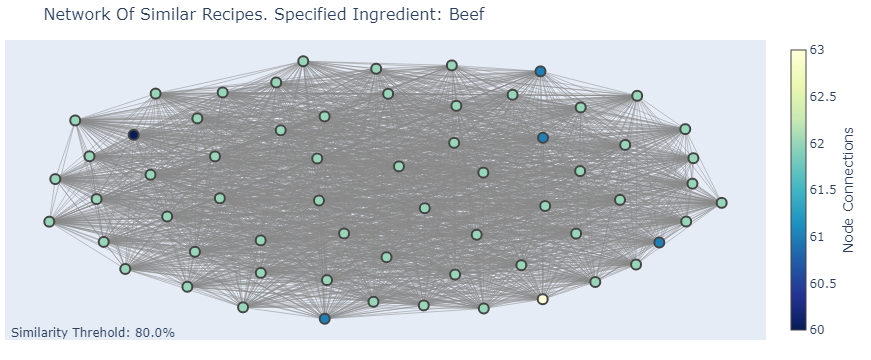

In [343]:
network_graph(0.8,"beef",f="similar")

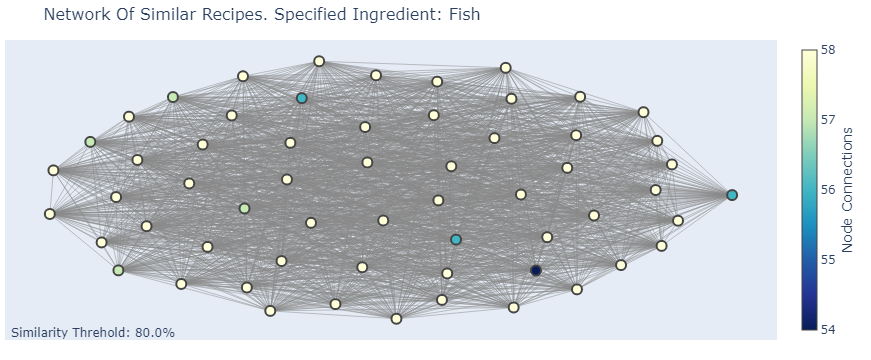

In [346]:
network_graph(0.8,"fish",f="complementary")

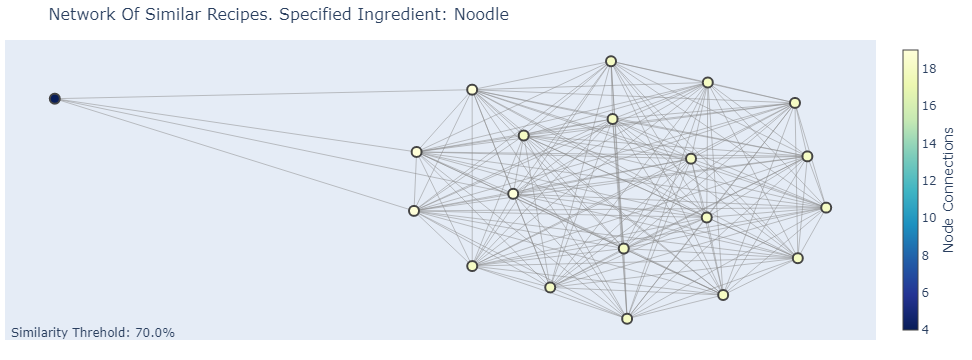

In [339]:
network_graph(0.7,"noodle",f="similar")

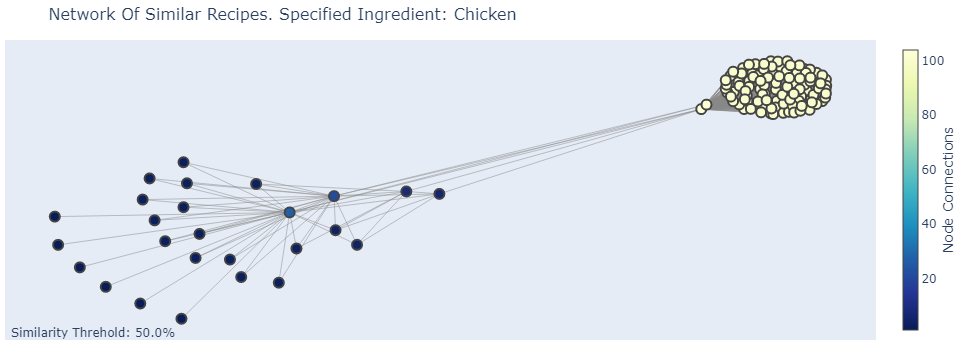

In [341]:
network_graph(0.5,"chicken",f="complementary")